# Classical Supervised Learning

Supervised machine learning is when we use a dataset **with known structure and/or features** to teach an algorithm how to approximate a function

$$ y = f(x) $$

between the data $x$ and the known outcome $y$. Classical machine learning is the machine learning algorithms that are not deep neural networks. Thus classical supervised learning is achieved by approximating the function $f$ using alternative methods to deep neural networks.

In this exercise notebook we will look at different datasets, their structure and how to classify the data in the datasets. On top of this we will see how shallow neural networks can be used as **universal function approximators**.

We will start by classifying the same dataset using different classification methods and how this affects the accuracy and the placement of the decision boundary in the dataset.

In [1]:
%matplotlib notebook
# %config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy import special
from IPython.core.display import display,HTML
display(HTML("<style>.container{ width: 100% !important;} <\style>"))
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,append=True)

## Aside: plotting code

I have provided a plotting code to plot the results of a classifier and the decision boundaries. This is provided as an easy to use function as I didn't see the need for anyone else to have to struggle with `matplotlib` to make these plots.

In [2]:
def class_plot(data,targets,feature_names,classifier,rang=0.25):
    '''
    A function to make the boundary contour plots.
    
    Parameters
    ----------
    data : numpy.ndarray
        The feature data.
    targets : numpy.ndarray
        The labels of the data samples.
    feature_names : list
        A list of the names of the features to be compared.
    classifier : various
        The class instance for the classifier being used after training.
    rang : float
        Defines the range of the x-axis and y-axis.
    '''
    
    x_min, x_max = data[:,0].min() - rang, data[:,0].max() + rang
    y_min, y_max = data[:,1].min() - rang, data[:,1].max() + rang
    
    xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max,0.02))
    
    if hasattr(classifier,"decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(),yy.ravel()])[:,1].reshape(xx.shape)

    cm = ListedColormap(["#FF0000","#0000FF"])

    plt.figure()
    plt.contourf(xx,yy,Z,cmap="RdBu",alpha=0.8)
    plt.scatter(data[:,0],data[:,1],c=targets,cmap=cm)
    plt.ylabel(feature_names[1])
    plt.xlabel(feature_names[0])

## Classification Dataset

Next we must load the dataset. The data is saved in ```.npz``` format. This is a data format native to ```numpy``` and works to save multiple ```numpy``` arrays to disk without losing any information. For more information check out the [`scipy` documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.lib.format.html#module-numpy.lib.format). ```.npz``` is essentially a ```.zip``` of ```numpy``` arrays. Loading a ```.npz``` file returns a ```dict```-like object where the arrays have the keys corresponding to the names assigned when saving the file. e.g.

```python
>>> import numpy as np
>>> a = np.array([[1,2],[3,4]])
>>> np.savez_compressed("a.npz",data=a)
>>> f = np.load("a.npz")
>>> f["data"] == a
array([[True, True],
       [True, True]])
```

In the example above, we use the function ```savez_compressed``` to save the data which creates a compressed ```.npz``` file but the function ```savez``` to create an uncompressed ```.npz``` file also exists (but when loading the data will make your code slower. ```.npz``` files preserve the structure of the arrays so there is no need to worry about doing any data manipulations when working with these files.

In [3]:
data = np.load("data.npz")

In [4]:
list(data.keys()) #this tells you what is in the dataset

['features', 'labels']

## Classification Method #1: The Perceptron

The perceptron is the simplest machine learning algorithm as it consists of a linear transformation followed by a non-linear step function to calculate its output. This is essentially one "neuron" of a layer of a neural network. This can be trained for only linear tasks and our dataset is a non-linear binary classification set which can be reflected in the perfomance.

1. Create a perceptron instance.
2. Next, fit this to the data and check the accuracy.
3. Lastly, plot your reduced data showing the decision boundaries using the plotting code provided.

**Feel free to change the tolerance level in the perceptron class instance to try to improve convergence (or make it worse).**
**Make sure to always choose** `random_state` **to be the same number when creating the class instance otherwise it will train differently every time.**

In [5]:
X, y = data["features"], data["labels"]

In [6]:
p = Perceptron(tol=1e-3,random_state=0)
p.fit(X,y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
p.score(X,y)

0.83

<IPython.core.display.Javascript object>


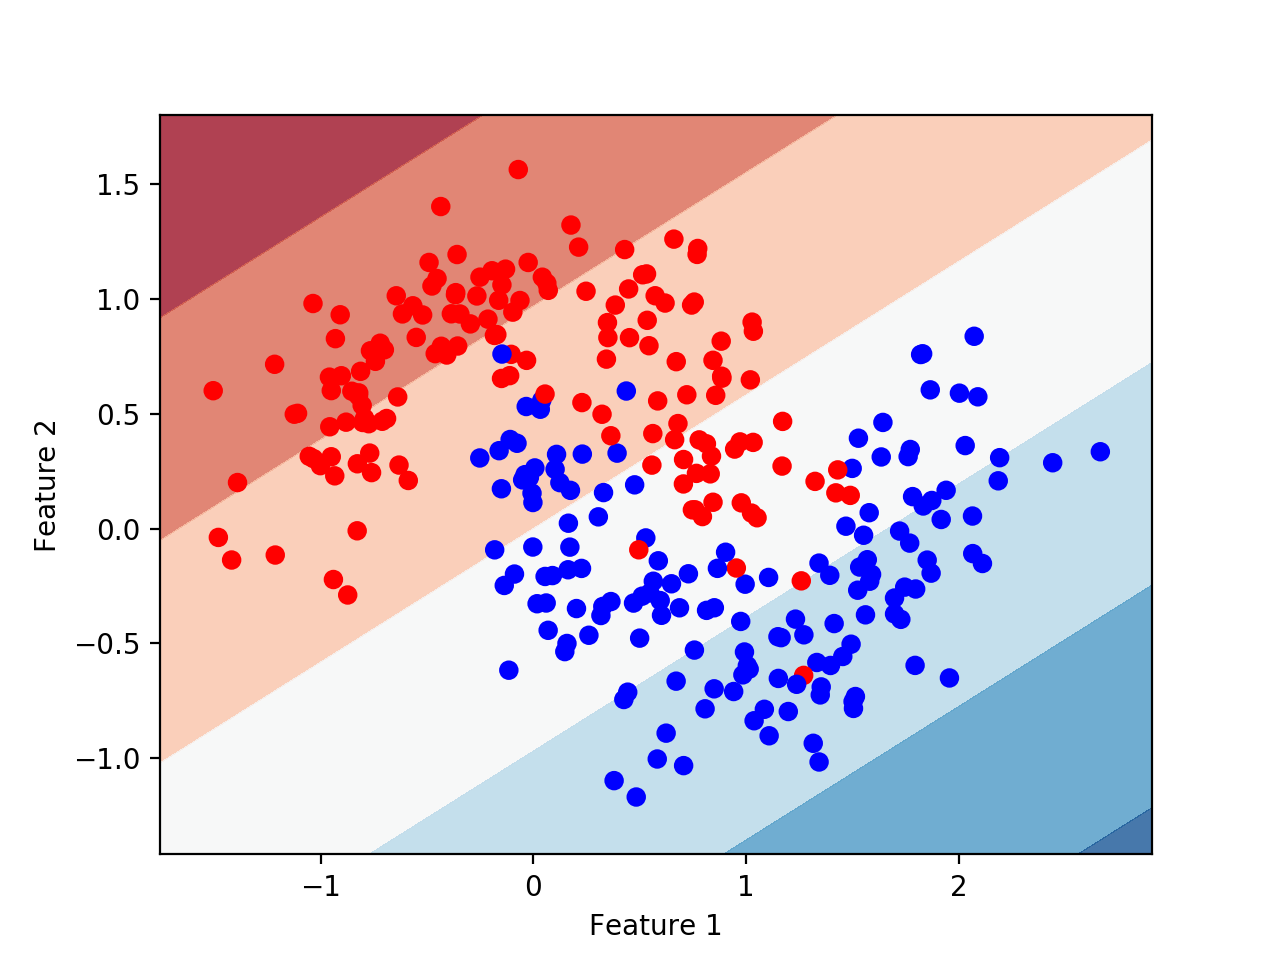

In [8]:
class_plot(X,y,["Feature 1","Feature 2"],p)

## Classification Method #2: K-Nearest Neighbours

K-nearest neighbours is a instance-based classifier and rather than learning a general model, this method learns information about the training data (i.e. where they lie in the 2D plane) to choose where to put the data it has not seen before. Classification in this case is performed by a majority vote, the distance from a point to the k nearest neighbours is calculated and the minimal distance defines what class the point belongs to.

The process is the same as that above.

**Try different numbers of nearest neighbours to see which gives you the best accuracy.**

In [9]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [10]:
knn.score(X,y)

0.9733333333333334

<IPython.core.display.Javascript object>


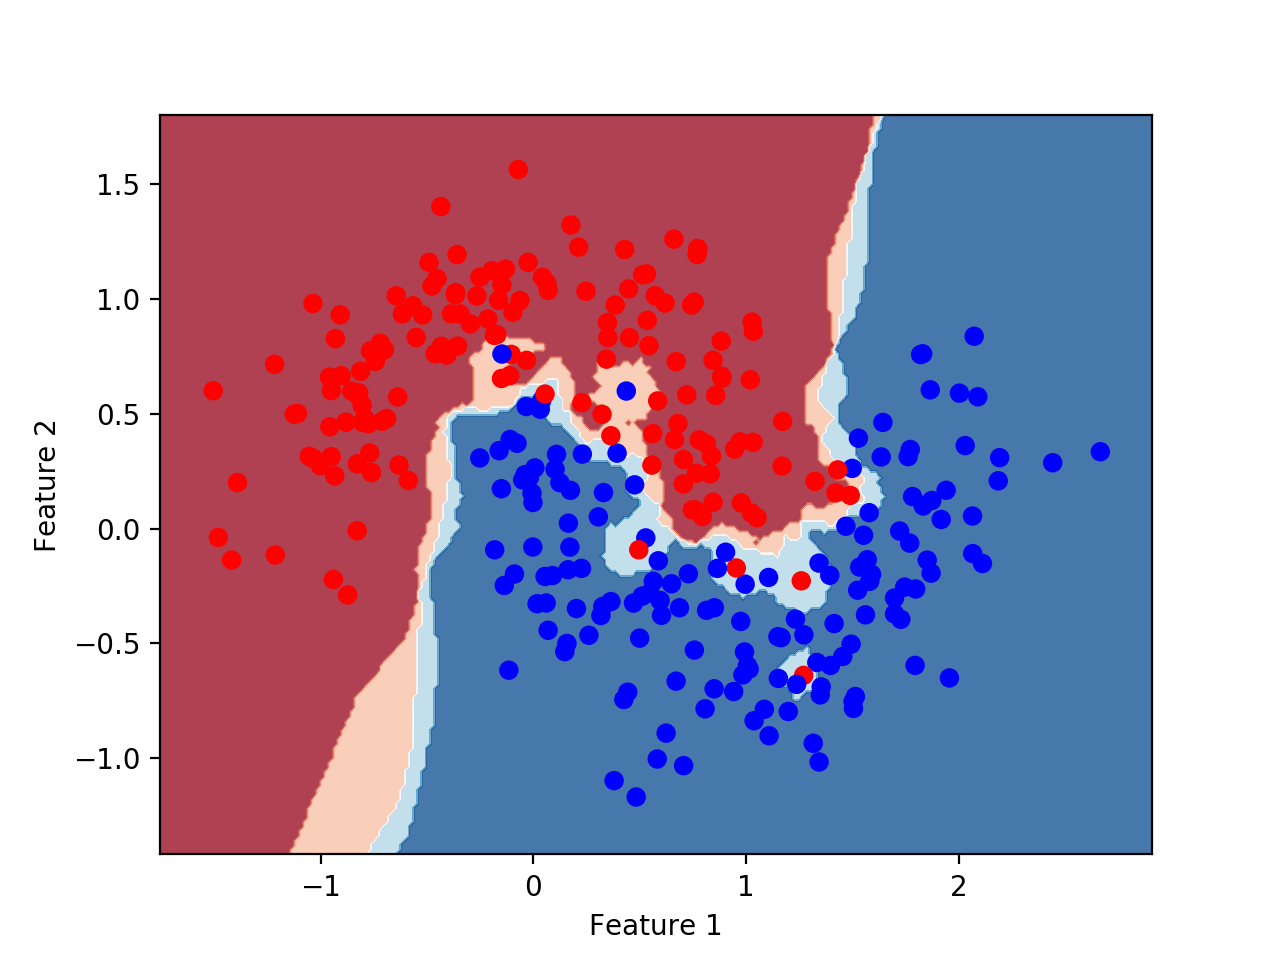

In [11]:
class_plot(X,y,["Feature 1","Feature 2"],knn)

## Classification Method #3: Gaussian Processes

A Gaussian process is one in which each of the classes in the dataset is assumed to be normally distributed i.e. drawn from a multivariate normal distribution. The distribution of the entire process is then the joint distribution of the features and is thus a continuous distribution in the space we are working.

We start from the assumption that each class is drawn from a normal with zero mean and a covariance matrix that we would like to learn to represent the data. This covariance matrix is often referred to as the kernel of the Gaussian process and is something that can be changed to yield different results. Starting from a Gaussian and calculating the covariance between the points in the classes allows the distribution of each class to be jointly updated until convergence.

**For the dataset provided, try different covariance matrices to see which converges the best.**

In [12]:
gp = GaussianProcessClassifier()
gp.fit(X,y)

GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [13]:
gp.score(X,y)

0.91

<IPython.core.display.Javascript object>


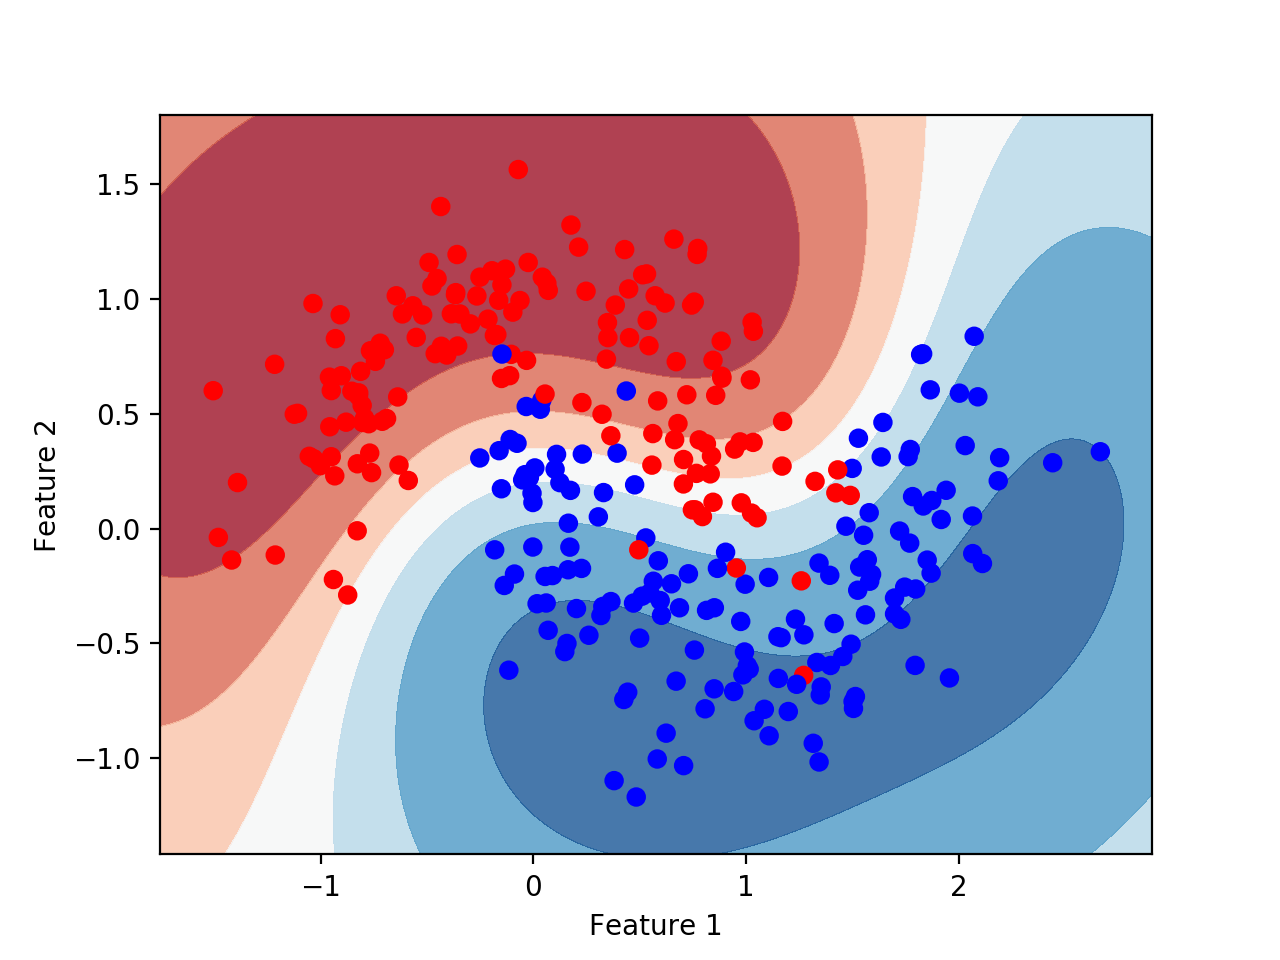

In [14]:
class_plot(X,y,["Feature 1","Feature 2"],gp)

## Classification Method #4: Support Vector Machine (SVM)

The last classification technique we will employ is the support vector machine (SVM). Support vector machines find a non-linear transformation in the dimension one higher than the dimension of the data to find a hyperplane which makes the data linearly separable. The "support vectors" are the points in the plane closest to the boundary of this hyperplane to help refine the position of it.

**Try different kernels to see which transformation yields the best solution.**

In [15]:
svm = SVC()
svm.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
svm.score(X,y)

0.9566666666666667

<IPython.core.display.Javascript object>


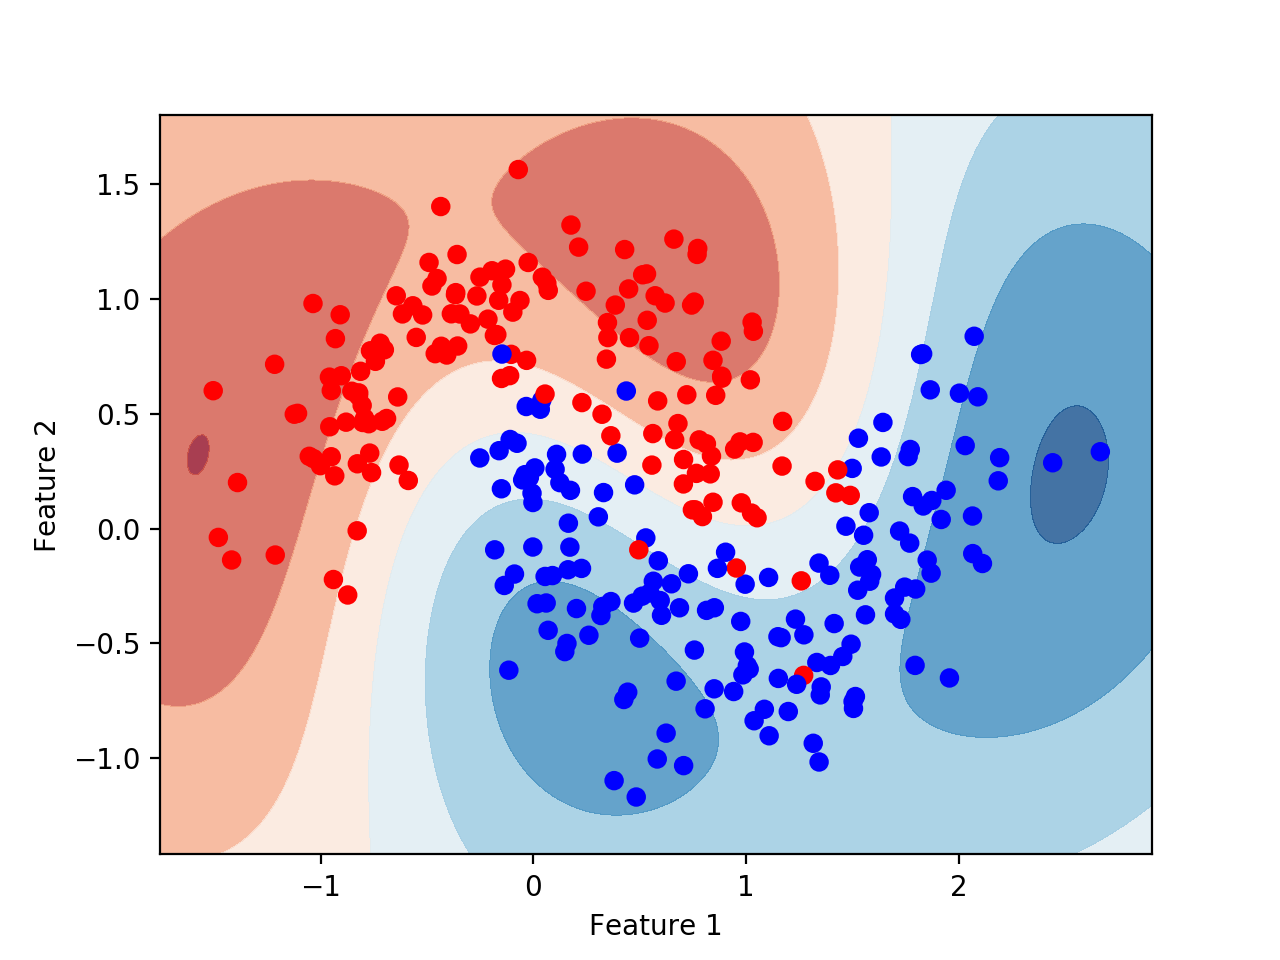

In [17]:
class_plot(X,y,["Feature 1","Feature 2"],svm)

## Function Approximation using SVMs and Neural Networks

The follow is an exercise on function approximating with support vector machines (SVMs) and neural networks. The neural network here has one layer between the input and output and is well-versed at function approximation. The dataset we use here is `voigt.npz`. This is the Voigt H function for damping factor a = 1, i.e.,

$$ H (a, v) = \frac{a}{\pi} \int_{0}^{\infty} \frac{e^{- (v^{\prime})^{2}}}{(a^{2} + (v - v^{\prime})^{2}} dv^{\prime} $$

The profile made for a range in v and a = 1 then has random Gaussian noise applied to it and we want to see how well we can approximate this, first using an SVM and second using a shallow neural network. After learning the function try plotting the true line profile (also given in the data file) to see how well your fit done.

In [18]:
voigt = np.load("voigt.npz")

In [19]:
list(voigt.keys())

['inputs', 'profile', 'true_profile']

In [20]:
X, y = voigt["inputs"], voigt["profile"]

In [21]:
svm = SVR()
svm.fit(X.reshape(-1,1),y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
y_rbf = svm.predict(X.reshape(-1,1))

<IPython.core.display.Javascript object>


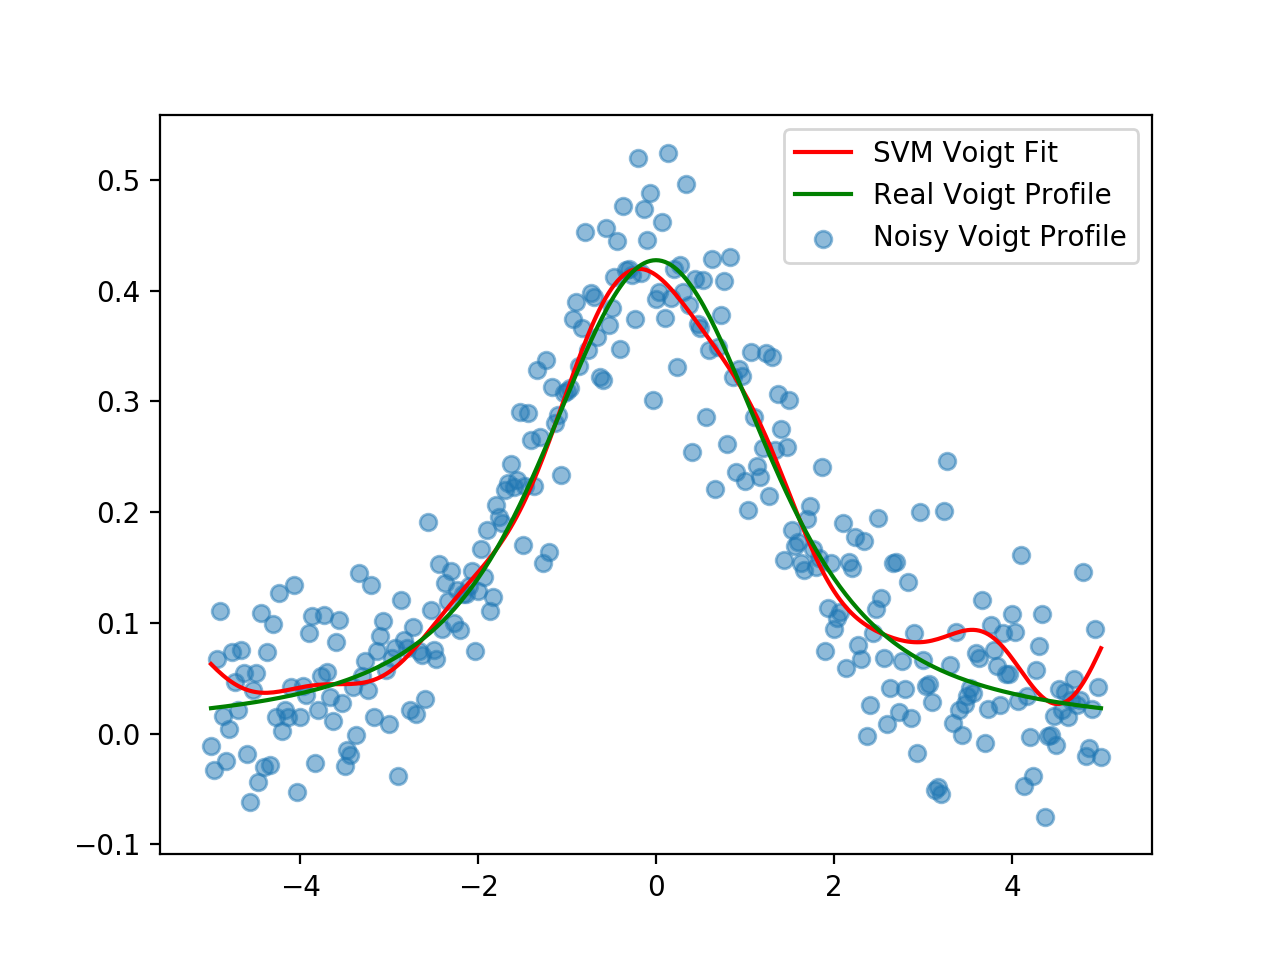

In [23]:
plt.figure()
plt.plot(X,y_rbf,label="SVM Voigt Fit",color="r")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Profile")
plt.plot(X,voigt["true_profile"],label="Real Voigt Profile",color="g")
plt.legend()

For the neural network approach we must define the model, the datasets, the loss function and the numerical method for optimisation. A template for this example is shown below but can be edited if you feel the need to.

In [24]:
model = nn.Sequential(
    nn.Linear(1,100),
    nn.Sigmoid(),
    nn.Linear(100,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.01)

In [25]:
xy = np.stack((X,y),axis=1)
xy_train, xy_test = train_test_split(xy,test_size=0.1)
x_train, y_train = xy_train[:,0], xy_train[:,1]
x_test, y_test = xy_test[:,0], xy_test[:,1]

In [26]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(x_train).float(),torch.from_numpy(y_train).float()),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(x_test).float(),torch.from_numpy(y_test).float()))

In [27]:
for t in range(500):
    for item, ans in train_loader:
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

    print(t, loss_test.item())

0 0.005366710014641285
1 0.003409544238820672
2 0.0019723372533917427
3 0.0029717166908085346
4 0.001317030400969088
5 0.0030097367707639933
6 0.0008661881438456476
7 0.0005215931450948119
8 0.0007499592611566186
9 8.51284039526945e-06
10 0.001356956665404141
11 0.0003637853660620749
12 2.3894855985417962e-05
13 0.0007298215059563518
14 0.002448128070682287
15 0.0001680810091784224
16 9.532611147733405e-05
17 0.012711257673799992
18 0.005091329570859671
19 0.0027635768055915833
20 0.0025201791431754827
21 0.00017906642460729927
22 0.002102939411997795
23 0.00020269688684493303
24 0.0015998408198356628
25 0.003884286852553487
26 0.006505677476525307
27 0.00020602934819180518
28 0.008646000176668167
29 0.003959151916205883
30 0.001818835618905723
31 0.0024604324717074633
32 0.0004244701412972063
33 0.0005218436708673835
34 0.0023349716793745756
35 1.365156549582025e-05
36 0.0017167001497000456
37 0.00448519317433238
38 0.005779652390629053
39 2.461195435898844e-05
40 0.001252480898983776

323 0.016196101903915405
324 0.002836259314790368
325 0.005005406215786934
326 0.0019847212824970484
327 0.003910020925104618
328 6.853436934761703e-05
329 0.0026827859692275524
330 0.0004528633726295084
331 0.00034529465483501554
332 0.00266731483861804
333 4.534412801149301e-05
334 0.0019469148246571422
335 0.00042554657557047904
336 0.0030420159455388784
337 0.0020569968037307262
338 0.005726174917072058
339 5.3118550567887723e-05
340 8.236619032686576e-05
341 0.0007398277521133423
342 0.0038752947002649307
343 0.000933683302719146
344 0.000976075476501137
345 0.0011410758597776294
346 0.0035433105658739805
347 0.011867164634168148
348 0.0034146972466260195
349 0.0003220088256057352
350 0.006582373753190041
351 0.0004893945879302919
352 0.003988079261034727
353 7.619700681971153e-06
354 0.0008267374360002577
355 0.01160421222448349
356 0.002011404139921069
357 0.0020878443028777838
358 0.008397752419114113
359 0.0024019619449973106
360 0.00011031037865905091
361 9.426238102605566e-0

In [28]:
#generate a random x vector for input to the model which will calculate a learned profile (only slightly badly....)
x_test = torch.linspace(-5,5,steps=301)
with torch.no_grad():
    y_test = model(x_test.unsqueeze(1))

<IPython.core.display.Javascript object>


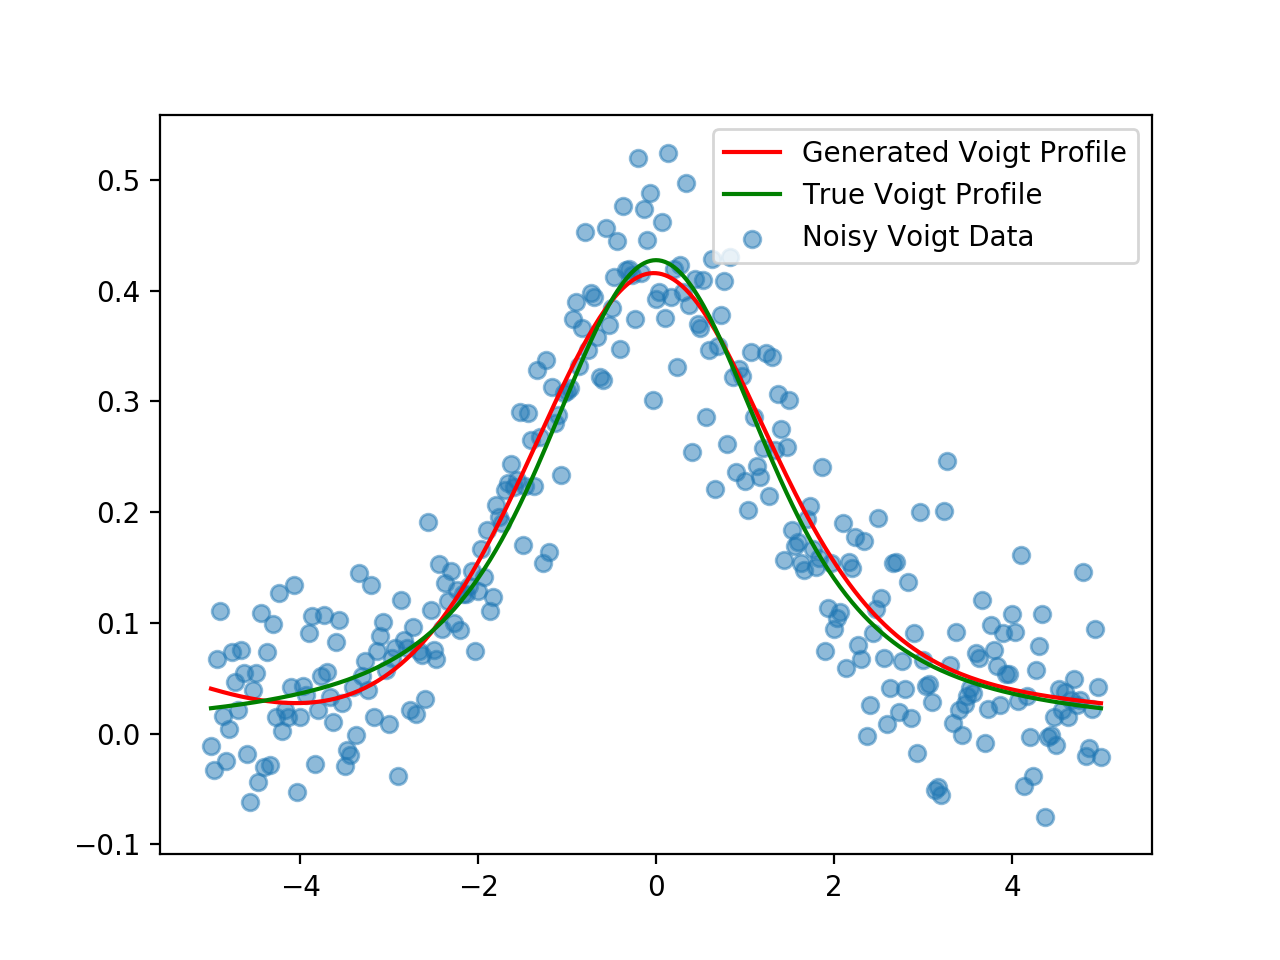

In [29]:
plt.figure()
plt.plot(x_test.numpy(),y_test.numpy(),"r",label="Generated Voigt Profile")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Data")
plt.plot(X,voigt["true_profile"],"g",label="True Voigt Profile")
plt.legend()

## More complex function approximation using NNs

We now generalise our neural network to learn the Voigt profile for arbitrary damping factor, a (where previously we have taken a = 1). Now load in the data containing many Voigt functions. Here we train a shallow neural network to try to learn the general voigt function (the data is already provided in `general_voigt.npz`).

Try training for 500 epochs and see how well you can generate a Voigt profile by creating your own with damping factor 0 $\leq$ a $\leq$ 2. The function for making a Voigt profile is provided below.

In [30]:
def voigt_H(a,v):
    z = v + 1j * a
    return special.wofz(z).real

In [31]:
general_voigt = np.load("general_voigt.npz")

In [32]:
list(general_voigt.keys())

['a_range', 'train_data', 'test_data']

In [33]:
model = nn.Sequential(
    nn.Linear(2,1000),
    nn.Sigmoid(),
    nn.Linear(1000,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.001)

In [34]:
train_input = np.stack((general_voigt["train_data"][:,:,0].flatten(),general_voigt["train_data"][:,:,1].flatten()),axis=1)
train_output = general_voigt["train_data"][:,:,2].flatten()
test_input = np.stack((general_voigt["test_data"][:,:,0].flatten(),general_voigt["test_data"][:,:,1].flatten()),axis=1)
test_output = general_voigt["test_data"][:,:,2].flatten()

In [35]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_input),torch.from_numpy(train_output)),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_input),torch.from_numpy(test_output)))

In [36]:
for t in range(500):
    loss_list = []
    for item, ans in train_loader:
        item, ans = item.float(), ans.float()
        
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            item, ans = item.float(), ans.float()
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

            loss_list.append(loss_test.item())
    print(t, np.mean(loss_list))

0 0.007236019935920174
1 0.01046921174272211
2 0.013010540364787208
3 0.01527603437707579
4 0.005909108061876724
5 0.005923565927921729
6 0.0051697728806681725
7 0.005293959039732804
8 0.005430146237703193
9 0.004698758466719884
10 0.0048717412812578275
11 0.005144683309207001
12 0.008408924119908665
13 0.004591300869560565
14 0.005442193665077131
15 0.005105370349914093
16 0.0051293853472375054
17 0.012183588739623186
18 0.004119979170891181
19 0.003859298355360907
20 0.004470997986009396
21 0.004616462068665877
22 0.0035409143263734977
23 0.004184887181884889
24 0.005190426749073368
25 0.003438772345797067
26 0.0040879711724387
27 0.01043301788206232
28 0.00334768792137056
29 0.0033505721724452707
30 0.0038169043184300036
31 0.0033705794524282596
32 0.003846818466389323
33 0.003728845257434776
34 0.018711687895257557
35 0.0038949006124915217
36 0.003132705632180827
37 0.00315751940485889
38 0.0031228910766817326
39 0.0031707950652713657
40 0.0031458566987516367
41 0.00322930789320143

326 0.0007303929400446778
327 0.0007494262865950478
328 0.0007822216067039488
329 0.0006835518914955677
330 0.0007908119189384645
331 0.0013676817072604782
332 0.0006983698080211722
333 0.0006516560676684508
334 0.002335464577844094
335 0.0008437257224361199
336 0.0006631073353844992
337 0.000718787890725337
338 0.0016711608688049723
339 0.0007025830694412325
340 0.000994804150753416
341 0.0006345305737028334
342 0.0008479009073306402
343 0.0009574320709678018
344 0.0007496845949215322
345 0.0006824362861098961
346 0.0006170742601205569
347 0.0007994890729433471
348 0.0006280471953196933
349 0.0006304529776243898
350 0.0006178758734668355
351 0.001055398292363215
352 0.0007117461511979028
353 0.0008740838865701552
354 0.0006169230665006825
355 0.0005870537086790572
356 0.0006532182467441512
357 0.0006517364085561902
358 0.0007880223671671449
359 0.0006909569710867322
360 0.0005703447030901587
361 0.0006418187714568412
362 0.0006109538821303271
363 0.0006622482560336298
364 0.0005721408

In [37]:
v_range = np.linspace(-5,5,num=51)
a_vec = np.empty_like(v_range)
a_vec.fill(0)
x_test = np.stack((a_vec,v_range),axis=1)

x_test_tensor = torch.from_numpy(x_test).float()
with torch.no_grad():
    y_test_tensor = model(x_test_tensor)
    
real_profile = voigt_H(0,v_range)

<IPython.core.display.Javascript object>


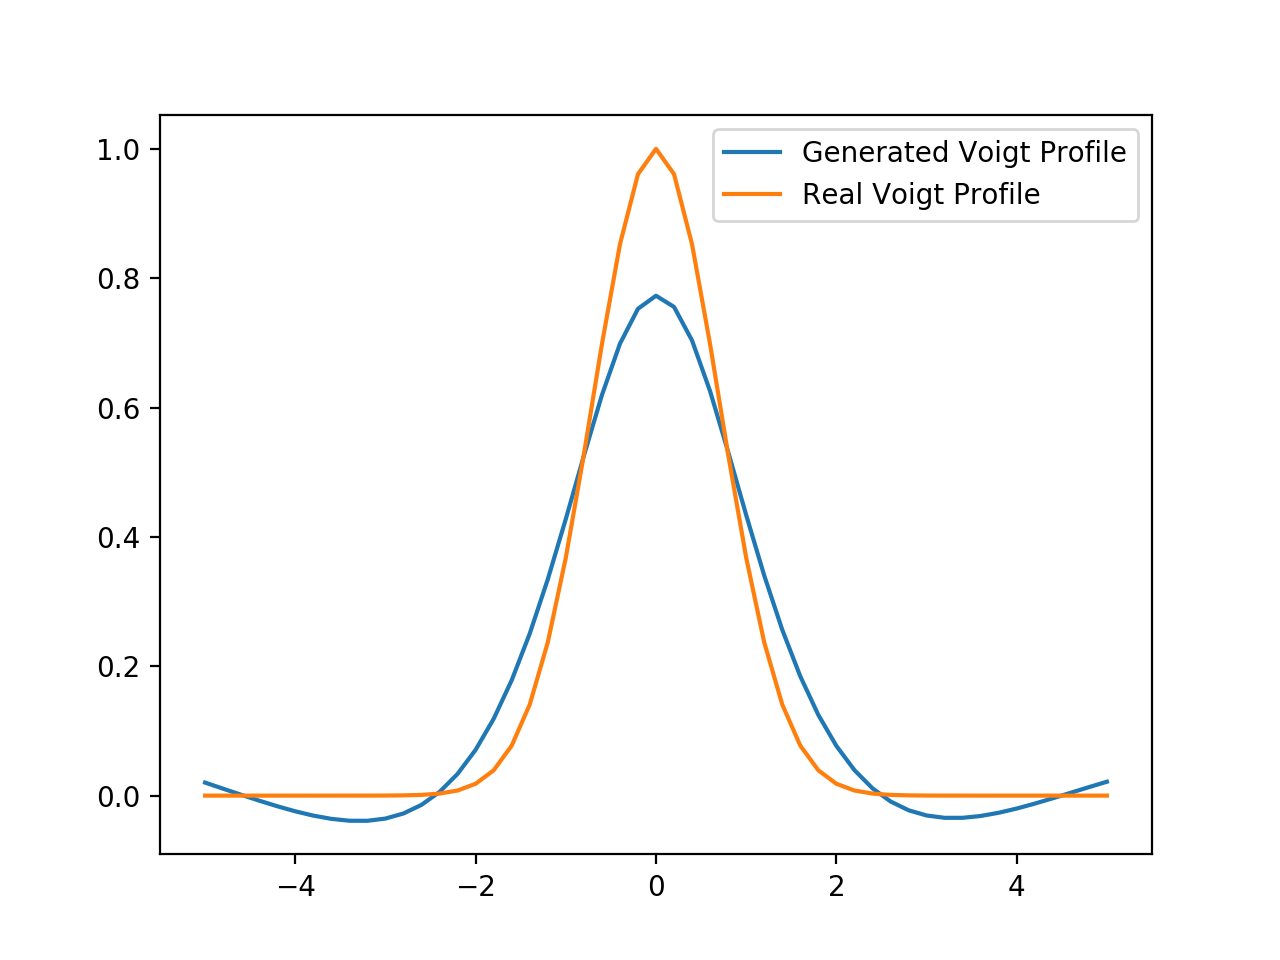

In [38]:
plt.figure()
plt.plot(v_range,y_test_tensor.numpy(),label="Generated Voigt Profile")
plt.plot(v_range,real_profile,label="Real Voigt Profile")
plt.legend()